In [25]:
import numpy as np
import pandas as pd
# para calculas métricas del modelo
from sklearn.metrics import mean_squared_error
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
# misc
import os
import time
import itertools
import warnings
warnings.filterwarnings("ignore")

# apartado ts
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing, Holt

#from prophet import Prophet

In [3]:
df_products = pd.read_csv('./data/Top100_prediction_sin.csv')
df_products.head(5)

,Unnamed: 0,id,date,sales,item,sell_price,income
0,103,ACCESORIES_1_108_NYC_1,2011-01-29,4,ACCESORIES_1_108,16.1196,64.4784
1,591,HOME_&_GARDEN_1_027_NYC_1,2011-01-29,4,HOME_&_GARDEN_1_027,6.5500,26.2000
2,615,HOME_&_GARDEN_1_053_NYC_1,2011-01-29,0,HOME_&_GARDEN_1_053,18.7125,0.0000
3,700,HOME_&_GARDEN_1_140_NYC_1,2011-01-29,4,HOME_&_GARDEN_1_140,18.7500,75.0000
4,737,HOME_&_GARDEN_1_177_NYC_1,2011-01-29,0,HOME_&_GARDEN_1_177,9.9625,0.0000


In [4]:
df_products.drop(columns=['Unnamed: 0'], axis=1, inplace=True)

In [5]:
df_product = df_products[['date', 'sales','item']]

In [6]:
df_product.head(2)

,date,sales,item
0,2011-01-29,4,ACCESORIES_1_108
1,2011-01-29,4,HOME_&_GARDEN_1_027


In [7]:
df_SUPERMARKET_3_586 = df_product[df_product['item']=='SUPERMARKET_3_586']

In [8]:
ts_predict = df_SUPERMARKET_3_586.groupby(['date'])['sales'].sum().reset_index() #ts=suma de todas las ventas de todas las tiendas agrupado por día

In [9]:
ts_predict.set_index('date', inplace=True)

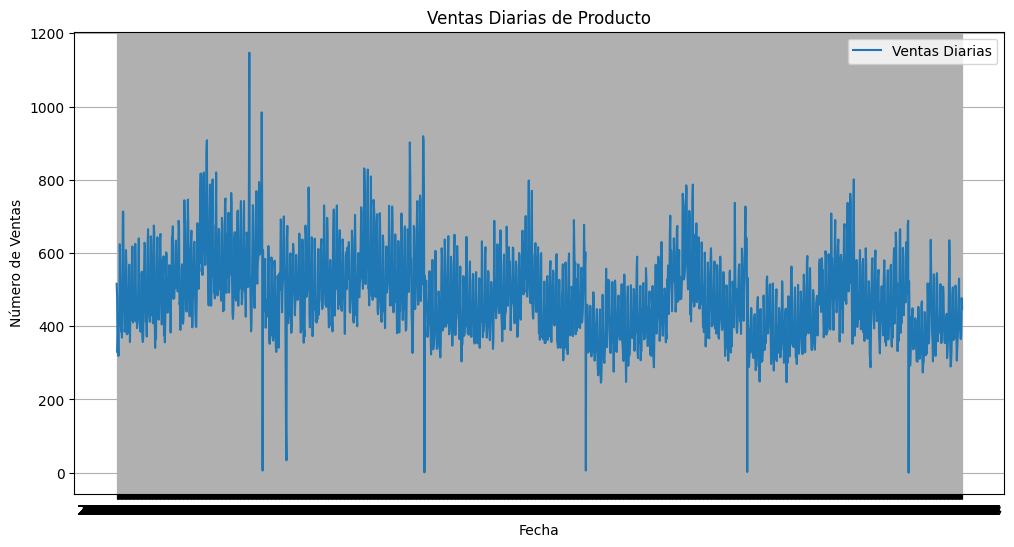

In [11]:
import matplotlib.pyplot as plt

# Graficar la serie temporal
plt.figure(figsize=(12, 6))
plt.plot(ts_predict.index, ts_predict['sales'], label='Ventas Diarias')
plt.xlabel('Fecha')
plt.ylabel('Número de Ventas')
plt.title('Ventas Diarias de Producto')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(ts_predict['sales'])
print(f'Estadístico ADF: {result[0]}')
print(f'Valor p: {result[1]}')

Estadístico ADF: -3.2812837267020893
Valor p: 0.015736104534793766


NameError: name 'plt' is not defined

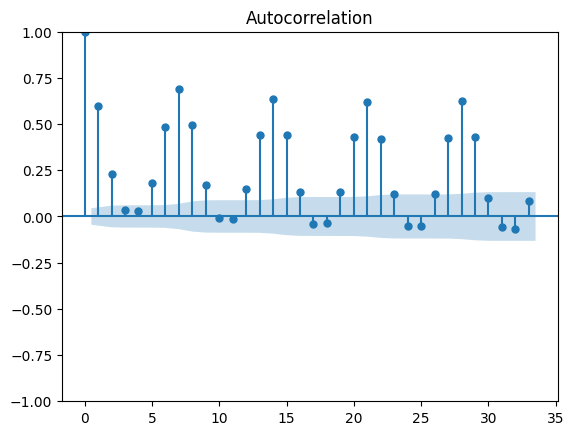

In [11]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_predict)
plt.show()

plot_pacf(ts_predict)
plt.show()

In [32]:
df_train = ts_predict[:-30]
df_test = ts_predict[-30:]

In [14]:
df_train

,sales
date,
2011-01-29,516
2011-01-30,479
2011-01-31,328
2011-02-01,376
2011-02-02,319
...,...
2016-02-27,545
2016-02-28,492
2016-02-29,359


In [15]:
pdq = [
    (1, 0, 1), (1, 0, 2),
    (2, 0, 3), (2, 0, 4),
    (2, 0, 5), (2, 0, 1),
    (2, 0, 2), (2, 0, 3),
    (2, 0, 4), (2, 0, 5),

    
    
    # Opciones con d = 1 (por si acaso)
    # (1, 1, 1), (1, 1, 2),
    # (2, 1, 1), (2, 1, 2)

    (1, 1, 1), (1, 1, 2),
    (2, 1, 3), (2, 1, 4),
    (2, 1, 5), (2, 1, 1),
    (2, 1, 2), (2, 1, 3),
    (2, 1, 4), (2, 1, 5)
]

# Probar también con algún P o Q diferente de 0 en la parte estacional
seasonal_pdq = (0, 1, 0, 7) # Actual
#     (1, 1, 0, 7),  # AR estacional
#     (0, 1, 1, 7),  # MA estacional
#     (1, 1, 1, 7)   # AR y MA estacional

In [35]:
RESULTS_DICT = {}

for param in pdq:

    model = sm.tsa.statespace.SARIMAX(
        endog = df_train,
        order = param,
        seasonal_order = seasonal_pdq,
        enforce_stationarity = False,
        enforce_invertibility = False
    )

    model_fitted = model.fit()

    print('ARIMA{}x{}12 - AIC:{}'.format(param, seasonal_pdq, model_fitted.aic))

    RESULTS_DICT[param] = round(model_fitted.aic, 2)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.83760D+00    |proj g|=  5.48076D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      2      5      1     0     0   6.926D-06   5.838D+00
  F =   5.8375983334727293     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


ARIMA(1, 0, 1)x(0, 1, 0, 7)12 - AIC:21990.395323858298
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.83466D+00    |proj g|=  4.35925D-03

At iterate    5    f=  5.83455D+00    |proj g|=  7.10215D-03


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      8     10      1     0     0   8.591D-06   5.835D+00
  F =   5.8345191153721672     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 0, 2)x(0, 1, 0, 7)12 - AIC:21980.79898849158
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.86525D+00    |proj g|=  5.21626D-01


 This problem is unconstrained.



At iterate    5    f=  5.92027D+00    |proj g|=  7.23850D-01

At iterate   10    f=  5.80061D+00    |proj g|=  1.53061D-01

At iterate   15    f=  5.78994D+00    |proj g|=  3.67508D-01

At iterate   20    f=  5.76241D+00    |proj g|=  1.99913D-01

At iterate   25    f=  5.75867D+00    |proj g|=  9.43683D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     29     69      2     0     0   1.862D-04   5.759D+00
  F =   5.7586616797277221     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 0, 3)x(0, 1, 0, 7)12 - AIC:21699.1198858546
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.82774D+00    |proj g|=  4.59385D-02


 This problem is unconstrained.



At iterate    5    f=  5.81964D+00    |proj g|=  1.16040D-02

At iterate   10    f=  5.81928D+00    |proj g|=  3.85759D-03

At iterate   15    f=  5.81673D+00    |proj g|=  8.46208D-02

At iterate   20    f=  5.78879D+00    |proj g|=  1.88223D-01

At iterate   25    f=  5.75483D+00    |proj g|=  5.82329D-02

At iterate   30    f=  5.75428D+00    |proj g|=  1.64397D-02

At iterate   35    f=  5.75376D+00    |proj g|=  2.92486D-03

At iterate   40    f=  5.75370D+00    |proj g|=  2.83790D-02

At iterate   45    f=  5.75360D+00    |proj g|=  2.60773D-02

At iterate   50    f=  5.75333D+00    |proj g|=  2.61867D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.79556D+00    |proj g|=  1.42685D-01

At iterate   10    f=  5.75309D+00    |proj g|=  3.11119D-01

At iterate   15    f=  5.72807D+00    |proj g|=  2.10081D-01

At iterate   20    f=  5.72611D+00    |proj g|=  5.05281D-02

At iterate   25    f=  5.72489D+00    |proj g|=  1.24628D-02

At iterate   30    f=  5.72476D+00    |proj g|=  2.42599D-03

At iterate   35    f=  5.72475D+00    |proj g|=  6.26009D-03

At iterate   40    f=  5.72448D+00    |proj g|=  7.09419D-02

At iterate   45    f=  5.72048D+00    |proj g|=  1.00171D-01

At iterate   50    f=  5.71624D+00    |proj g|=  1.77461D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  5.87178D+00    |proj g|=  3.33101D-01

At iterate   10    f=  5.83390D+00    |proj g|=  4.61685D-02

At iterate   15    f=  5.83320D+00    |proj g|=  1.38857D-03

At iterate   20    f=  5.83188D+00    |proj g|=  4.78706D-02

At iterate   25    f=  5.82521D+00    |proj g|=  1.25225D-02

At iterate   30    f=  5.82518D+00    |proj g|=  2.25993D-03

At iterate   35    f=  5.82514D+00    |proj g|=  3.18119D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     39     54      1     0     0   1.246D-04   5.825D+00
  F =   5.8251418658299396     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  5.92027D+00    |proj g|=  7.23850D-01

At iterate   10    f=  5.80061D+00    |proj g|=  1.53061D-01

At iterate   15    f=  5.78994D+00    |proj g|=  3.67508D-01

At iterate   20    f=  5.76241D+00    |proj g|=  1.99913D-01

At iterate   25    f=  5.75867D+00    |proj g|=  9.43683D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     29     69      2     0     0   1.862D-04   5.759D+00
  F =   5.7586616797277221     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 0, 3)x(0, 1, 0, 7)12 - AIC:21699.1198858546
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.82774D+00    |proj g|=  4.59385D-02


 This problem is unconstrained.



At iterate    5    f=  5.81964D+00    |proj g|=  1.16040D-02

At iterate   10    f=  5.81928D+00    |proj g|=  3.85759D-03

At iterate   15    f=  5.81673D+00    |proj g|=  8.46208D-02

At iterate   20    f=  5.78879D+00    |proj g|=  1.88223D-01

At iterate   25    f=  5.75483D+00    |proj g|=  5.82329D-02

At iterate   30    f=  5.75428D+00    |proj g|=  1.64397D-02

At iterate   35    f=  5.75376D+00    |proj g|=  2.92486D-03

At iterate   40    f=  5.75370D+00    |proj g|=  2.83790D-02

At iterate   45    f=  5.75360D+00    |proj g|=  2.60773D-02

At iterate   50    f=  5.75333D+00    |proj g|=  2.61867D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.79556D+00    |proj g|=  1.42685D-01

At iterate   10    f=  5.75309D+00    |proj g|=  3.11119D-01

At iterate   15    f=  5.72807D+00    |proj g|=  2.10081D-01

At iterate   20    f=  5.72611D+00    |proj g|=  5.05281D-02

At iterate   25    f=  5.72489D+00    |proj g|=  1.24628D-02

At iterate   30    f=  5.72476D+00    |proj g|=  2.42599D-03

At iterate   35    f=  5.72475D+00    |proj g|=  6.26009D-03

At iterate   40    f=  5.72448D+00    |proj g|=  7.09419D-02

At iterate   45    f=  5.72048D+00    |proj g|=  1.00171D-01

At iterate   50    f=  5.71624D+00    |proj g|=  1.77461D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


  ys=-1.530E-02  -gs= 1.466E-02 BFGS update SKIPPED

At iterate    5    f=  5.84437D+00    |proj g|=  1.08203D-01

At iterate   10    f=  5.84435D+00    |proj g|=  9.00577D-03

At iterate   15    f=  5.84431D+00    |proj g|=  1.38471D-01

At iterate   20    f=  5.84199D+00    |proj g|=  4.20920D-01

At iterate   25    f=  5.83866D+00    |proj g|=  7.69511D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     29     41      1     1     0   5.763D-05   5.839D+00
  F =   5.8386317535161663     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 1)x(0, 1, 0, 7)12 - AIC:21994.287183741882
RUNNIN

 This problem is unconstrained.



At iterate    5    f=  5.83880D+00    |proj g|=  4.08629D-03

At iterate   10    f=  5.83875D+00    |proj g|=  4.51911D-02

At iterate   15    f=  5.83864D+00    |proj g|=  1.70595D-02

At iterate   20    f=  5.83772D+00    |proj g|=  1.03152D-01

At iterate   25    f=  5.83373D+00    |proj g|=  1.24856D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     37      1     0     0   7.949D-05   5.834D+00
  F =   5.8335176589215596     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 2)x(0, 1, 0, 7)12 - AIC:21977.027503498593
RUNNING THE L-BFGS-B CODE

           * * *

Machine preci

 This problem is unconstrained.



At iterate    5    f=  5.92052D+00    |proj g|=  1.63722D-01

At iterate   10    f=  5.83935D+00    |proj g|=  3.26022D-01

At iterate   15    f=  5.80992D+00    |proj g|=  2.34304D-01

At iterate   20    f=  5.80913D+00    |proj g|=  1.07602D-01

At iterate   25    f=  5.78468D+00    |proj g|=  2.75659D-01

At iterate   30    f=  5.78370D+00    |proj g|=  1.09419D-01

At iterate   35    f=  5.78291D+00    |proj g|=  2.86147D-03

At iterate   40    f=  5.78291D+00    |proj g|=  5.46864D-03

At iterate   45    f=  5.78278D+00    |proj g|=  7.35532D-02

At iterate   50    f=  5.78055D+00    |proj g|=  2.14879D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.83348D+00    |proj g|=  8.97781D-03

At iterate   10    f=  5.82895D+00    |proj g|=  1.61367D-01

At iterate   15    f=  5.80033D+00    |proj g|=  1.75992D-01

At iterate   20    f=  5.78037D+00    |proj g|=  1.86593D-01

At iterate   25    f=  5.77583D+00    |proj g|=  9.98191D-03

At iterate   30    f=  5.77506D+00    |proj g|=  4.81316D-02

At iterate   35    f=  5.77493D+00    |proj g|=  2.67985D-03

At iterate   40    f=  5.77491D+00    |proj g|=  5.24744D-02

At iterate   45    f=  5.77319D+00    |proj g|=  1.92007D-01

At iterate   50    f=  5.76923D+00    |proj g|=  5.33185D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


  ys=-1.548E-03  -gs= 3.756E-02 BFGS update SKIPPED

At iterate    5    f=  5.83037D+00    |proj g|=  9.78080D-02

At iterate   10    f=  5.82896D+00    |proj g|=  5.78364D-02

At iterate   15    f=  5.82340D+00    |proj g|=  2.27034D-01

At iterate   20    f=  5.79738D+00    |proj g|=  2.57248D-01

At iterate   25    f=  5.78216D+00    |proj g|=  8.68325D-02

At iterate   30    f=  5.78150D+00    |proj g|=  2.49325D-03

At iterate   35    f=  5.78077D+00    |proj g|=  1.25445D-01

At iterate   40    f=  5.77956D+00    |proj g|=  2.48826D-02

At iterate   45    f=  5.77932D+00    |proj g|=  6.31498D-02

At iterate   50    f=  5.77902D+00    |proj g|=  4.61334D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final 

 This problem is unconstrained.



At iterate    5    f=  5.84264D+00    |proj g|=  1.38832D-02

At iterate   10    f=  5.84254D+00    |proj g|=  2.78504D-02

At iterate   15    f=  5.84177D+00    |proj g|=  3.71007D-01

At iterate   20    f=  5.83802D+00    |proj g|=  1.57734D-01

At iterate   25    f=  5.83670D+00    |proj g|=  3.89184D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     37      1     0     0   1.516D-04   5.837D+00
  F =   5.8366962871415362     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 1, 1)x(0, 1, 0, 7)12 - AIC:21988.998217375025
RUNNING THE L-BFGS-B CODE

           * * *

Machine preci

 This problem is unconstrained.



At iterate    5    f=  5.86127D+00    |proj g|=  4.77986D-01

At iterate   10    f=  5.84024D+00    |proj g|=  4.89571D-02

At iterate   15    f=  5.84011D+00    |proj g|=  3.62129D-01

At iterate   20    f=  5.83985D+00    |proj g|=  1.45506D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     29      1     0     0   1.455D-02   5.840D+00
  F =   5.8398525999467044     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 1, 2)x(0, 1, 0, 7)12 - AIC:22002.884891399288


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.88170D+00    |proj g|=  7.74618D+02

At iterate    5    f=  5.92052D+00    |proj g|=  1.63722D-01

At iterate   10    f=  5.83935D+00    |proj g|=  3.26022D-01

At iterate   15    f=  5.80992D+00    |proj g|=  2.34304D-01

At iterate   20    f=  5.80913D+00    |proj g|=  1.07602D-01

At iterate   25    f=  5.78468D+00    |proj g|=  2.75659D-01

At iterate   30    f=  5.78370D+00    |proj g|=  1.09419D-01

At iterate   35    f=  5.78291D+00    |proj g|=  2.86147D-03

At iterate   40    f=  5.78291D+00    |proj g|=  5.46864D-03

At iterate   45    f=  5.78278D+00    |proj g|=  7.35532D-02

At iterate   50    f=  5.78055D+00    |proj g|=  2.14879D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  5.83348D+00    |proj g|=  8.97781D-03

At iterate   10    f=  5.82895D+00    |proj g|=  1.61367D-01

At iterate   15    f=  5.80033D+00    |proj g|=  1.75992D-01

At iterate   20    f=  5.78037D+00    |proj g|=  1.86593D-01

At iterate   25    f=  5.77583D+00    |proj g|=  9.98191D-03

At iterate   30    f=  5.77506D+00    |proj g|=  4.81316D-02

At iterate   35    f=  5.77493D+00    |proj g|=  2.67985D-03

At iterate   40    f=  5.77491D+00    |proj g|=  5.24744D-02

At iterate   45    f=  5.77319D+00    |proj g|=  1.92007D-01

At iterate   50    f=  5.76923D+00    |proj g|=  5.33185D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


  ys=-1.548E-03  -gs= 3.756E-02 BFGS update SKIPPED

At iterate    5    f=  5.83037D+00    |proj g|=  9.78080D-02

At iterate   10    f=  5.82896D+00    |proj g|=  5.78364D-02

At iterate   15    f=  5.82340D+00    |proj g|=  2.27034D-01

At iterate   20    f=  5.79738D+00    |proj g|=  2.57248D-01

At iterate   25    f=  5.78216D+00    |proj g|=  8.68325D-02

At iterate   30    f=  5.78150D+00    |proj g|=  2.49325D-03

At iterate   35    f=  5.78077D+00    |proj g|=  1.25445D-01

At iterate   40    f=  5.77956D+00    |proj g|=  2.48826D-02

At iterate   45    f=  5.77932D+00    |proj g|=  6.31498D-02

At iterate   50    f=  5.77902D+00    |proj g|=  4.61334D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final 

In [37]:
gsx = list(map(str, list(RESULTS_DICT.keys())))
gsy = list(RESULTS_DICT.values())

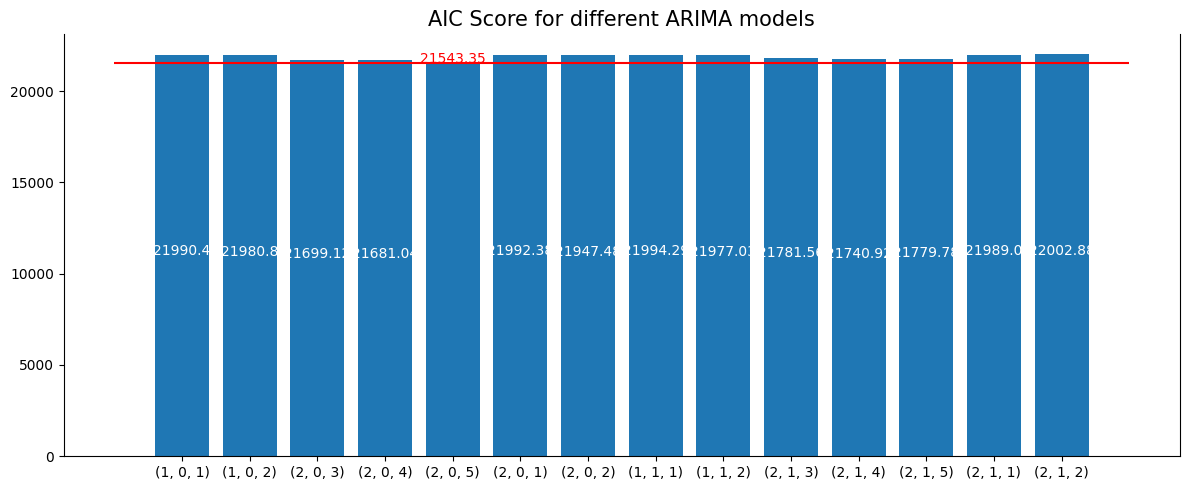

In [38]:
fig = plt.figure(figsize = (12, 5))
ax = fig.add_subplot()

ax.bar(x = gsx, height = gsy)
ax.hlines(y = min(gsy), xmin = -1, xmax = len(gsx), color = "red")

for xtick_, y_ in zip(gsx, gsy):

    s_ = str(round(y_, 2))

    ax.text(
        x = xtick_,
        y = y_/2 if y_ != min(gsy) else y_ + 10,
        s = s_,
        ha = "center",
        color = "red" if y_ == min(gsy) else "white"
    )

ax.spines["top"].set_color("None")

plt.title(label = "AIC Score for different ARIMA models", fontsize = 15)
plt.tight_layout()

In [39]:
RESULTS_DICT

{(1, 0, 1): 21990.4,
 (1, 0, 2): 21980.8,
 (2, 0, 3): 21699.12,
 (2, 0, 4): 21681.04,
 (2, 0, 5): 21543.35,
 (2, 0, 1): 21992.38,
 (2, 0, 2): 21947.48,
 (1, 1, 1): 21994.29,
 (1, 1, 2): 21977.03,
 (2, 1, 3): 21781.56,
 (2, 1, 4): 21740.92,
 (2, 1, 5): 21779.78,
 (2, 1, 1): 21989.0,
 (2, 1, 2): 22002.88}

In [40]:
idx_min_score_aic = np.argmin(list(RESULTS_DICT.values()))
pdq_min_score_aic = list(RESULTS_DICT.keys())[idx_min_score_aic]
min_score_aic = RESULTS_DICT[pdq_min_score_aic]

message = f'''
El score mínimo se alcanza con ARIMA{pdq_min_score_aic}
Con un score AIC de {min_score_aic}.
En la posición {idx_min_score_aic}
'''

print(message)


El score mínimo se alcanza con ARIMA(2, 0, 5)
Con un score AIC de 21543.35.
En la posición 4



In [43]:
best_arima_model = sm.tsa.statespace.SARIMAX(
    endog = df_train,
    order = (2,0,4),
    seasonal_order = seasonal_pdq,
    enforce_stationarity = False,
    enforce_invertibility = False
)

best_arima_model_fitted = best_arima_model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.82774D+00    |proj g|=  4.59385D-02


 This problem is unconstrained.



At iterate    5    f=  5.81964D+00    |proj g|=  1.16040D-02

At iterate   10    f=  5.81928D+00    |proj g|=  3.85759D-03

At iterate   15    f=  5.81673D+00    |proj g|=  8.46208D-02

At iterate   20    f=  5.78879D+00    |proj g|=  1.88223D-01

At iterate   25    f=  5.75483D+00    |proj g|=  5.82329D-02

At iterate   30    f=  5.75428D+00    |proj g|=  1.64397D-02

At iterate   35    f=  5.75376D+00    |proj g|=  2.92486D-03

At iterate   40    f=  5.75370D+00    |proj g|=  2.83790D-02

At iterate   45    f=  5.75360D+00    |proj g|=  2.60773D-02

At iterate   50    f=  5.75333D+00    |proj g|=  2.61867D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

In [36]:
print(best_arima_model_fitted.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9927      0.025     40.036      0.000       0.944       1.041
ar.L2         -0.6383      0.019    -33.334      0.000      -0.676      -0.601
ma.L1         -0.7721      0.026    -29.270      0.000      -0.824      -0.720
ma.L2          0.6182      0.025     24.702      0.000       0.569       0.667
ma.L3          0.2032      0.026      7.895      0.000       0.153       0.254
ma.L4          0.2132      0.027      7.755      0.000       0.159       0.267
sigma2      7089.3783    107.861     65.727      0.000    6877.975    7300.782


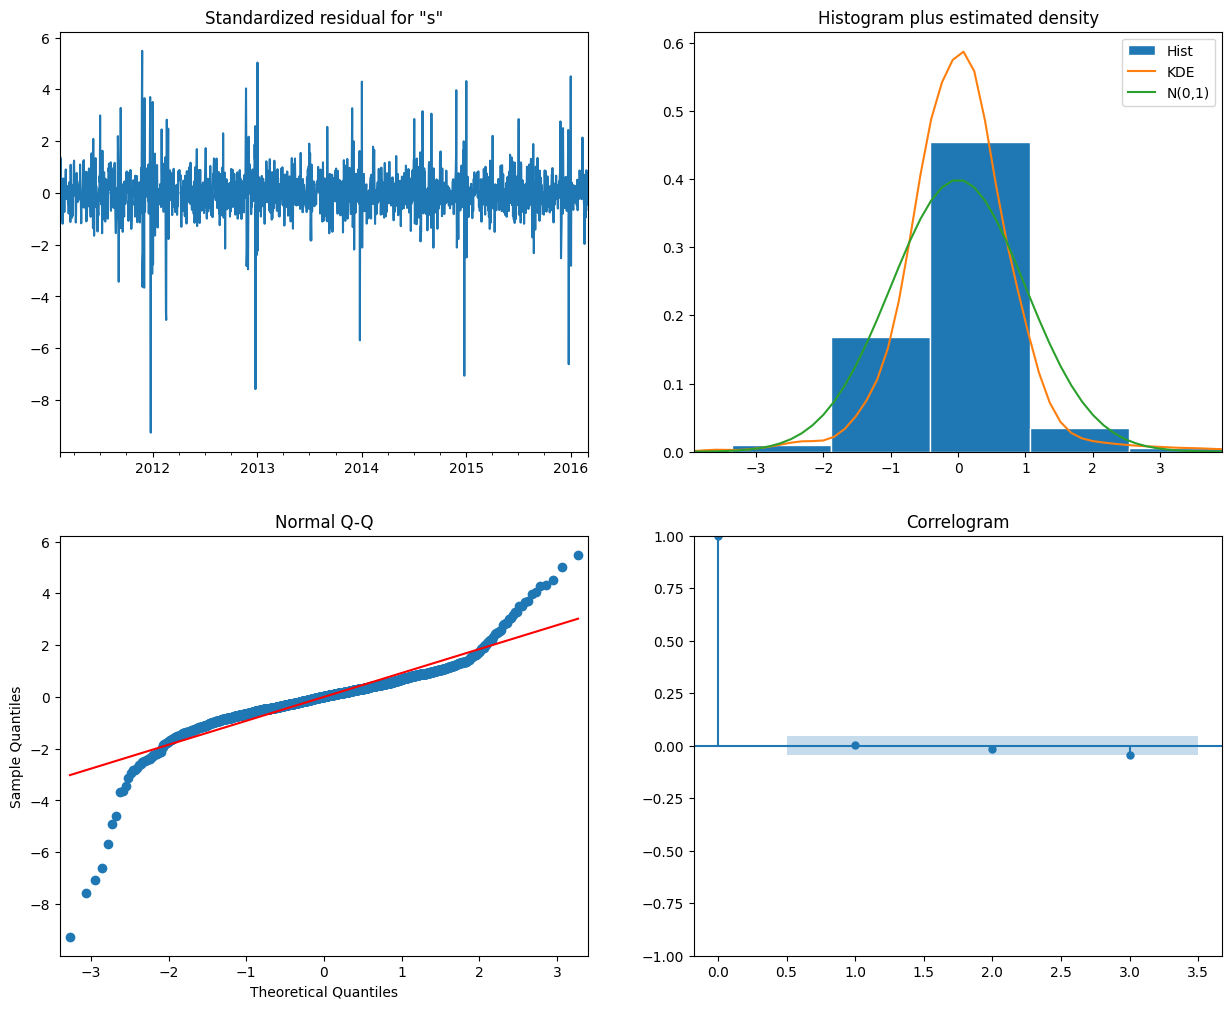

In [28]:
best_arima_model_fitted.plot_diagnostics(figsize = (15, 12), lags = 3);

In [56]:
# Para hacer una predicción es suficiente con especificar el número de steps/pasos futuros a estimar.
pred_uc = best_arima_model_fitted.get_forecast(steps = len(df_test))
y_pred_test = pred_uc.predicted_mean

# 1. Calcular el MSE
mse = mean_squared_error(df_test['sales'], y_pred_test)
print(mse)
# 2. Calcular el RMSPE
rmspe = np.sqrt(np.mean(((df_test['sales'] - y_pred_test) / df_test) ** 2)) * 100
print(rmspe)
rmse = np.sqrt(mean_squared_error(df_test['sales'], y_pred_test))
print(f'RMSE: {rmse}')

2814.5225526555546
nan
RMSE: 53.0520739712931


In [52]:
resultado = {'predicion': y_pred_test.values, 'test':df_test['sales']}

In [53]:
pd.DataFrame(resultado)

,predicion,test
date,,
2016-03-26,490.384362,635
2016-03-27,509.509165,579
2016-03-28,370.742857,339
2016-03-29,370.327024,290
2016-03-30,359.213842,300
2016-03-31,366.679101,332
2016-04-01,480.996940,405
2016-04-02,483.072512,485
2016-04-03,516.932686,506


In [54]:
ts_predict.reset_index(inplace=True)
ts_predict['date'] = pd.to_datetime(ts_predict['date'])
ts_predict.set_index('date', inplace=True)
#y_pred_test.set_index('date', inplace=True)

Text(0.5, 0.98, 'Lynx Values and ARIMA Forecast')

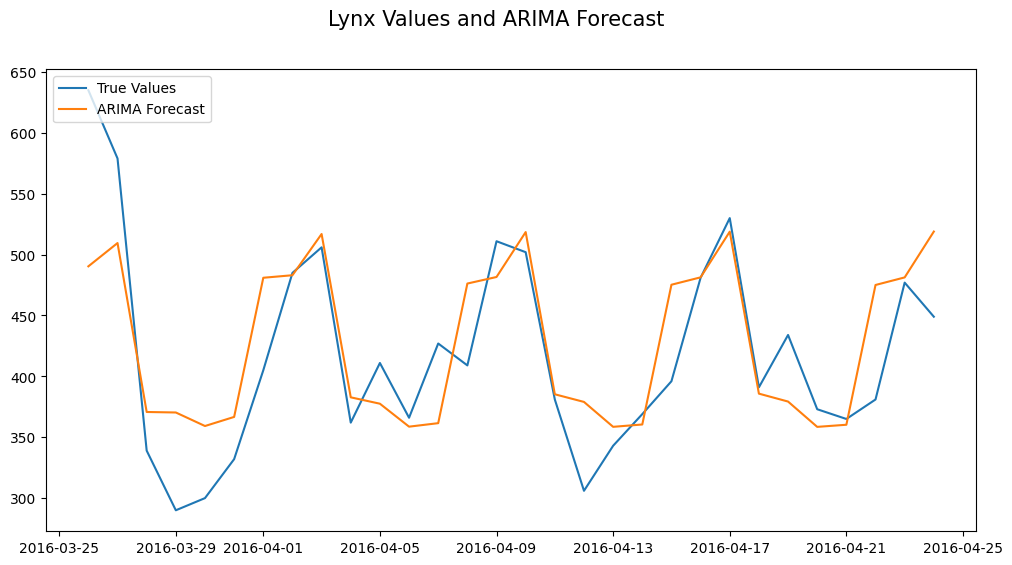

In [57]:
fig = plt.figure(figsize = (12, 6))
ax = fig.subplots()

ax.plot(ts_predict[-30:], label = "True Values")
ax.plot(y_pred_test, label = "ARIMA Forecast")

ax.legend(loc = "upper left")
fig.suptitle("Lynx Values and ARIMA Forecast", fontsize = 15)

In [40]:
from sklearn.metrics import mean_squared_error
import numpy as np

rmse = np.sqrt(mean_squared_error(df_test['sales'], y_pred_test))
print(f'RMSE: {rmse}')

RMSE: 51.681031903475905
